# 使用字符级RNN生成名称

`Ascend` `GPU` `进阶` `自然语言处理` `全流程`

[![](https://gitee.com/mindspore/docs/raw/r1.5/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r1.5/tutorials/source_zh_cn/intermediate/text/rnn_generation.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/r1.5/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r1.5/tutorials/zh_cn/mindspore_rnn_generation.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/r1.5/resource/_static/logo_modelarts.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9yMS41L3R1dG9yaWFscy96aF9jbi9taW5kc3BvcmVfcm5uX2dlbmVyYXRpb24uaXB5bmI=&imageid=59a6e9f5-93c0-44dd-85b0-82f390c5d53b)

## 概述

本教程中，我们将通过反向操作来生成不同语言的名称。这里仍通过编写由线性层结构构建出的小型RNN网络模型来实现目标。此次与[《使用字符级RNN分类名称》](https://www.mindspore.cn/tutorials/zh-CN/r1.5/intermediate/text/rnn_classification.html)这篇教程最大的区别在于，不是通过输入名称中的所有字母来预测分类，而是输入一个分类类别，然后一次输出一个字母，这种用于预测字符来形成一个单词的方法通常称为“语言模型”。

> 本篇基于GPU/Ascend环境运行。

## 准备环节

### 环境配置

本教程我们在Ascend环境下，使用PyNative模式运行实验。

In [1]:
from mindspore import context

context.set_context(mode=context.PYNATIVE_MODE, device_target="Ascend")

### 准备数据

数据集是来自18种语言的数千种姓氏，点击[这里](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/data.zip)下载数据，并将其提取到当前目录。

数据集目录结构为`data/names`，目录中包含 18 个文本文件，名称为`[Language].txt`。 每个文件包含一系列名称，每行一个名称。数据大多数是罗马化的，需要将其从Unicode转换为ASCII。

可在Jupyter Notebook中执行以下代码完成数据集的下载，并将数据集解压完成。

In [2]:
!wget -NP ./ https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/data.zip
!unzip ./data.zip

## 数据处理

- 导入模块。

In [3]:
import os
import glob
import string
import unicodedata
from io import open

- 定义`find_files`函数，查找符合通配符要求的文件。

In [4]:
def find_files(path): 
    return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names/German.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/Korean.txt', 'data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Russian.txt', 'data/names/Greek.txt', 'data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Polish.txt', 'data/names/Japanese.txt', 'data/names/Scottish.txt']


- 定义`unicode_to_ascii`函数，将Unicode转换为ASCII。

In [5]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Estéves'))

Esteves


- 定义`read_lines`函数，读取文件，并将文件每一行内容的编码转换为ASCII。

In [6]:
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

定义`category_lines`字典和`all_categories`列表。

- `category_lines`：key为语言的类别，value为名称的列表。
- `all_categories`：所有语言的种类。

In [7]:
category_lines = {}
all_categories = []

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

- 将所有语言的数量和种类进行打印显示。

In [8]:
print('# categories:', n_categories, all_categories)

# categories: 18 ['German', 'Dutch', 'English', 'Italian', 'Vietnamese', 'Portuguese', 'Korean', 'Spanish', 'French', 'Russian', 'Greek', 'Arabic', 'Irish', 'Chinese', 'Czech', 'Polish', 'Japanese', 'Scottish']


## 创建网络

该网络基于[《使用字符级RNN分类名称》](https://www.mindspore.cn/tutorials/zh-CN/r1.5/intermediate/text/rnn_classification.html)教程中的RNN网络进行了扩展，附加了一个与输入`input`和隐藏状态`hidden`连接在一起的类别`category`张量。该张量与字母输入一样采用one-hot编码。

该网络的输出为下一个字母出现的概率，将最有可能出现的字母作为下一次迭代的输入`input`。

与上一个网络结构略有不同，为了有更好的效果，在`output combined`层之后我们又添加了一个线性层`o2o`。与此同时也新添加了一个`dropout`层，该层以一定的概率（此处为0.1）将输入的部分随机归零。这一步骤通常用来防止过拟合。

![rnn2](https://gitee.com/mindspore/docs/raw/r1.5/tutorials/source_zh_cn/intermediate/text/images/run2.png)

In [9]:
import numpy as np

from mindspore import nn, ops, Tensor
from mindspore import dtype as mstype

class RNN(nn.Cell):
    """定义RNN网络"""
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Dense(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Dense(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Dense(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(axis=1)
   
    # 构建RNN网络结构
    def construct(self, category, input, hidden):
        op = ops.Concat(axis=1)
        input_combined = op((category, input, hidden))
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = op((hidden, output))
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    # 初始化隐层状态
    def initHidden(self):
        return Tensor(np.zeros((1, self.hidden_size)),mstype.float32)

## 训练

### 准备训练

- 通过`random_training_pair`函数随机选择一种语言和其中一个名称作为训练数据。

In [10]:
import random

# 随机选择
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

# 随机选择一种语言和一个名称
def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line

对于训练集中的每个名称，该网络的输入为：`(category, current letter, hidden state)`，输出为：`(next letter, next hidden state)`。因此对于每个训练集，我们都需要`categoryTensor`（代表种类的one-hot张量），用于输入的`inputTensor`（由首字母到尾字母（不包括EOS）组成的one-hot矩阵）和用于输出的`targetTensor`（由第二个字母到尾字母（包括EOS）组成的张量）。

因为我们需要预测当前字母所对应的下一个字母，所以需要拆分连续字母来组成字母对。例如：对于`"ABCD<EOS>"`，我们将创建出`('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'EOS')`字母对。

![pair](https://gitee.com/mindspore/docs/raw/r1.5/tutorials/source_zh_cn/intermediate/text/images/pair.png)

我们在训练时会持续将`category`张量传输至网络中，该张量维度为`<1 x n_categories>`的[one-hot张量](https://en.wikipedia.org/wiki/One-hot)。

- 定义`category_to_tensor`函数将类别转换成维度为`<1 x n_categories>`的one-hot张量。

In [11]:
def category_to_tensor(category):
    li = all_categories.index(category)
    tensor = Tensor(np.zeros((1, n_categories)),mstype.float32)
    tensor[0,li] = 1.0
    return tensor

- 定义`input_to_tensor`函数，将输入转换成一个由首字母到尾字母（不包括EOS）组成的one-hot矩阵。

In [12]:
def input_to_tensor(line):
    tensor = Tensor(np.zeros((len(line), 1, n_letters)), mstype.float32)
    for li in range(len(line)):
        letter = line[li]
        tensor[li,0,all_letters.find(letter)] = 1.0
    return tensor

- 定义`target_to_tensor`函数，将目标值准换成一个由第二个字母到尾字母(包括EOS)组成的张量。

In [13]:
def target_to_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    
    # 添加EOS
    letter_indexes.append(n_letters - 1)
    
    return Tensor(np.array(letter_indexes), mstype.int64)

为了方便训练，我们将使用`random_training`函数来获取随机对`(category，line)`，并将其转换为所需格式的`(category, input, target)`张量。

In [14]:
def random_training():
    category, line = random_training_pair()
    category_tensor = category_to_tensor(category)
    input_line_tensor = input_to_tensor(line)
    target_line_tensor = target_to_tensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### 训练网络

与分类模型依赖最后输出作为结果不同，这里我们在每一步都进行了预测，因此每一步都需要计算损失。

- 定义`NLLLoss`损失函数。

In [15]:
import mindspore.ops as ops

class NLLLoss(nn.LossBase):
    def __init__(self, reduction='mean'):
        super(NLLLoss, self).__init__(reduction)
        self.one_hot = ops.OneHot()
        self.reduce_sum = ops.ReduceSum()
        
    def construct(self, logits, label):
        label_one_hot = self.one_hot(label, ops.shape(logits)[-1], ops.scalar_to_array(1.0), ops.scalar_to_array(0.0))
        loss = self.reduce_sum(-1.0 * logits * label_one_hot, (1,))
        return self.get_loss(loss)

In [16]:
criterion = NLLLoss()

- MindSpore将损失函数，优化器等操作都封装到了Cell中，但是本教程rnn网络循环的每一步都需要计算损失，所以我们需要自定义`WithLossCell`类，将网络和Loss连接起来。

In [17]:
class WithLossCellRnn(nn.Cell):
    """构建有损失计算的RNN网络"""
    
    def __init__(self, backbone,loss_fn):
        super(WithLossCellRnn, self).__init__(auto_prefix=True)
        self._backbone = backbone
        self._loss_fn = loss_fn

    def construct(self, category_tensor, input_line_tensor, hidden, target_line_tensor):
        loss = 0
        for i in range(input_line_tensor.shape[0]):
            output, hidden = self._backbone(category_tensor, input_line_tensor[i], hidden)
            l = self._loss_fn(output, target_line_tensor[i])
            loss += l
        return loss

- 创建优化器、`WithLossCellRnn`实例和`TrainOneStepCell`训练网络。

In [18]:
rnn_cf = RNN(n_letters, 128, n_letters)
optimizer = nn.Momentum(filter(lambda x:x.requires_grad,rnn_cf.get_parameters()),0.0001,0.9)
net_with_criterion = WithLossCellRnn(rnn_cf, criterion)
net = nn.TrainOneStepCell(net_with_criterion, optimizer)
net.set_train()

# 训练网络
def train(category_tensor,input_line_tensor, target_line_tensor):
    new_shape = list(target_line_tensor.shape)
    new_shape.append(1)
    target_line_tensor = target_line_tensor.reshape(new_shape)
    hidden = rnn_cf.initHidden()
    loss = net(category_tensor, input_line_tensor, hidden,target_line_tensor)
    
    # 返回一个序列最后一个
    for i in range(input_line_tensor.shape[0]):
        output, hidden = rnn_cf(category_tensor, input_line_tensor[i], hidden)

    return  output, loss / input_line_tensor.shape[0]

- 为了跟踪网络模型训练过程中的耗时，定义`time_since`函数，用来计算训练运行的时间，方便我们持续看到训练的整个过程。

In [19]:
import time
import math

# 定义可读时间回调字符串
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

- 在训练过程中，每经过`print_every`（500）次迭代就打印一次，分别打印迭代所用时间、迭代次数、迭代进度和损失值。同时，根据`plot_every`的值计算平均损失，将其添加进`all_losses`列表，以便于后面绘制训练过程种损失函数的图像。

In [20]:
n_iters = 7500
print_every = 500
plot_every = 100
all_losses = []

# 每经过100次迭代，就重置为0
total_loss = 0 

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*random_training())
    total_loss += loss
    
    # 分别打印迭代所用时间、迭代次数、迭代进度和损失值
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f'% (time_since(start), iter, iter / n_iters * 100, loss.asnumpy())) 
    
    if iter % plot_every == 0:
        all_losses.append((total_loss / plot_every).asnumpy())
        total_loss = 0

5m 56s (500 6%) 3.7287
11m 37s (1000 13%) 4.1077
17m 8s (1500 20%) 4.0800
22m 51s (2000 26%) 4.1025
28m 28s (2500 33%) 4.0878
34m 3s (3000 40%) 4.0277
39m 38s (3500 46%) 4.0859
45m 22s (4000 53%) 3.9899
51m 7s (4500 60%) 3.5648
56m 52s (5000 66%) 4.0283
63m 34s (5500 73%) 4.0877
71m 50s (6000 80%) 4.0858
79m 42s (6500 86%) 4.1082
88m 11s (7000 93%) 3.7557
97m 32s (7500 100%) 4.0461


- 使用`matplotlib.pyplot`绘制训练过程中损失函数的图像。

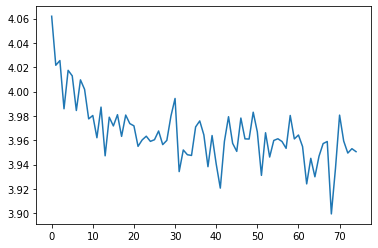

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## 验证模型

在训练结束后，对获得的模型进行验证。这里，我们向网络中输入一个字母并推理得出下一个字母。将输出的字母作为下一步的输入，重复直到EOS标记处。

In [23]:
max_length = 20

# 根据类别、起始字母、隐藏状态开始推理
def sample(category, start_letter='A'):
    category_tensor = category_to_tensor(category)
    input = input_to_tensor(start_letter)
    hidden = rnn_cf.initHidden()
    output_name = start_letter
    
    for i in range(max_length):
        output, hidden = rnn_cf(category_tensor, input[0], hidden)
        topk = ops.TopK(sorted=True)
        topv, topi = topk(output,1)
        topi = topi[0,0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = input_to_tensor(letter)
        
    return output_name

# 遍历提供的字母，得到输出名称
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print('语言类型：%s 首字母：%s 输出结果：%s' %(category, start_letter, sample(category, start_letter)))

samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

语言类型：Russian 首字母：R 输出结果：Rrnarao
语言类型：Russian 首字母：U 输出结果：Uilehidaauritai
语言类型：Russian 首字母：S 输出结果：Sa
语言类型：German 首字母：G 输出结果：Gallh
语言类型：German 首字母：E 输出结果：Ehuhkiakena
语言类型：German 首字母：R 输出结果：Rcsahonuianah
语言类型：Spanish 首字母：S 输出结果：Stadlalugtnaaa
语言类型：Spanish 首字母：P 输出结果：Perahaiarsaorrol
语言类型：Spanish 首字母：A 输出结果：Aaan
语言类型：Chinese 首字母：C 输出结果：Cadco
语言类型：Chinese 首字母：H 输出结果：Hn
语言类型：Chinese 首字母：I 输出结果：I
